# Convert VOC to TFRecord

Convert Pascal VOC dataset to TFRecord for object detection.

## 匯入相關函式庫 Import all the necessary libraries

In [1]:
import os
import glob
import xml.etree.ElementTree as ET
from datetime import datetime

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

tf.__version__

'2.0.0'

## 設定相關設定與參數 Setting parameters

In [2]:
# 訓練/驗證用的資料目錄
DATA_PATH = "../data"

# 資料集目錄
DATA_SET_PATH = os.path.join(DATA_PATH, "kangaroo")

# 資料集標註檔目錄
ANNOTATIONS_PATH = os.path.join(DATA_SET_PATH, "annots")

# 資料集圖像檔目錄
IMAGES_PATH = os.path.join(DATA_SET_PATH, "images")

# Classes that you want to detect.
CLASSES = ['kangaroo']

print(DATA_PATH)
print(DATA_SET_PATH)
print(ANNOTATIONS_PATH)
print(IMAGES_PATH)
print(CLASSES)

../data
../data/kangaroo
../data/kangaroo/annots
../data/kangaroo/images
['kangaroo']


## Explore Dataset: Process Image and Parse Annotation

In [3]:
def process_image(image_file):
    """Decode image at given path."""
    # Method 1: return <class 'tf.Tensor'>
    image_string = tf.io.read_file(image_file)
    
    # Method 2: return <class 'bytes'>
    #with open(image_file, 'rb') as f:
    #    image_string = f.read() # binary-string
    
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        #image_data = tf.image.resize(image_data, [300, 300])
        #image_data /= 255.0 # normalize to [0, 1] range
        return 0, image_string, image_data  
    except tf.errors.InvalidArgumentError:
        print('{}: Invalid JPEG data or crop window'.format(image_file))
        return 1, image_string, None

In [4]:
def parse_annot(annot_file):
    """Process Pascal VOC annotations."""
    tree = ET.parse(annot_file)
    root = tree.getroot()
    
    image_info = {}
    image_info_list = []
    
    file_name = root.find('filename').text
    
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    depth = int(size.find('depth').text)
    
    xmin, ymin, xmax, ymax = [], [], [], []
    classes = []

    for obj in root.iter('object'):
        label = obj.find('name').text
        
        if len(CLASSES) > 0 and label not in CLASSES:
            continue
        else:
            classes.append(CLASSES.index(label))
                           
        for box in obj.findall('bndbox'):
            xmin.append(float(box.find('xmin').text) / width)
            ymin.append(float(box.find('ymin').text) / height)
            xmax.append(float(box.find('xmax').text) / width)
            ymax.append(float(box.find('ymax').text) / height)
    
    image_info['filename'] = file_name
    image_info['width'] = width
    image_info['height'] = height
    image_info['depth'] = depth
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    
    image_info_list.append(image_info)
    
    return image_info_list

[{'filename': '00001.jpg', 'width': 450, 'height': 319, 'depth': 3, 'class': [0, 0], 'xmin': [0.5177777777777778, 0.29777777777777775], 'ymin': [0.27899686520376177, 0.329153605015674], 'xmax': [0.8577777777777778, 0.7577777777777778], 'ymax': [0.8213166144200627, 0.7931034482758621]}]
[{'filename': '00002.jpg', 'width': 550, 'height': 309, 'depth': 3, 'class': [0, 0], 'xmin': [0.28363636363636363, 0.4036363636363636], 'ymin': [0.36893203883495146, 0.3786407766990291], 'xmax': [0.43636363636363634, 0.7545454545454545], 'ymax': [1.0, 0.9902912621359223]}]


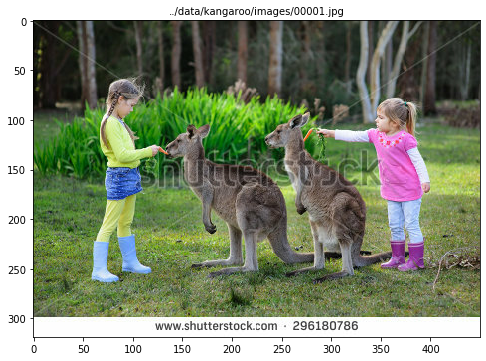

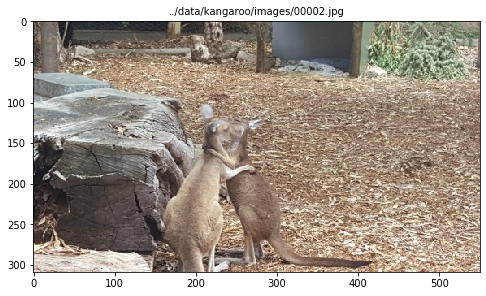

In [5]:
images = sorted(glob.glob(os.path.join(IMAGES_PATH, '*.jpg')))
annots = sorted(glob.glob(os.path.join(ANNOTATIONS_PATH, '*.xml')))
count = 0

for image, annot in (zip(images, annots)):
    count += 1
      
    error, image_string, image_data = process_image(image)
    image_info_list = parse_annot(annot)
    
    if count <= 2 and not error:
        print(image_info_list)
        
        f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
        f.subplots_adjust(hspace = .2, wspace=.05)
    
        ax1.imshow(image_data)
        ax1.set_title('{}'.format(image), fontsize=10)
    else:
        break

## Write the TFRecord file

More example, please reference [tensorflow2-tutorials: tfrecords](https://github.com/kaka-lin/tensorflow2-tutorials/tree/master/load_and_preprocess_data/tfrecords)

### Creating a `tf.Example` message

In [6]:
def convert_voc_to_tf_example(image_string, image_info_list):
    """Convert Pascal VOC ground truth to TFExample protobuf."""
    for info in image_info_list:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']
        
    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]
                
    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example # example.SerializeToString()

In [ ]:
example_proto = convert_voc_to_tf_example(image_string, image_info_list)
example_proto

### Writing the tf.Example to the TFRecord files

In [8]:
record_file = 'pascal.tfrecord'
with tf.io.TFRecordWriter(record_file) as writer:
    writer.write(example_proto.SerializeToString())

### Writing the all `tf.Example` message to the TFRecord files

In [9]:
!du -sh {record_file}

28K	pascal.tfrecord


In [10]:
def main():
    images = sorted(glob.glob(os.path.join(IMAGES_PATH, '*.jpg')))
    annots = sorted(glob.glob(os.path.join(ANNOTATIONS_PATH, '*.xml')))
    train_file = '../data/train_voc.tfrecord'
    counter = 0
    skipped = 0

    with tf.io.TFRecordWriter(train_file) as writer:
        for image, annot in (zip(images, annots)):
            # processes the image and parse the annotation
            error, image_string, image_data = process_image(image)
            image_info_list = parse_annot(annot)

            if not error:
                # convert voc to `tf.Example`
                example = convert_voc_to_tf_example(image_string, image_info_list)

                # write the `tf.example` message to the TFRecord files
                writer.write(example.SerializeToString())
                counter += 1
                print('{} : Processed {:d} of {:d} images.'.format(
                    datetime.now(), counter, len(images)))
            else:
                skipped += 1
                print('{} : Skipped {:d} of {:d} images.'.format(
                    datetime.now(), skipped, len(images)))

    print('{} : Wrote {} images to {}'.format(
            datetime.now(), counter, train_file))

In [11]:
main()

2019-10-04 01:06:39.392496 : Processed 1 of 164 images.
2019-10-04 01:06:39.405264 : Processed 2 of 164 images.
2019-10-04 01:06:39.414341 : Processed 3 of 164 images.
2019-10-04 01:06:39.427442 : Processed 4 of 164 images.
2019-10-04 01:06:39.440605 : Processed 5 of 164 images.
2019-10-04 01:06:39.451510 : Processed 6 of 164 images.
2019-10-04 01:06:39.463844 : Processed 7 of 164 images.
2019-10-04 01:06:39.478486 : Processed 8 of 164 images.
2019-10-04 01:06:39.494800 : Processed 9 of 164 images.
2019-10-04 01:06:39.511307 : Processed 10 of 164 images.
2019-10-04 01:06:39.524666 : Processed 11 of 164 images.
2019-10-04 01:06:39.544182 : Processed 12 of 164 images.
2019-10-04 01:06:39.556544 : Processed 13 of 164 images.
2019-10-04 01:06:39.571613 : Processed 14 of 164 images.
2019-10-04 01:06:39.585820 : Processed 15 of 164 images.
2019-10-04 01:06:39.608212 : Processed 16 of 164 images.
2019-10-04 01:06:39.640455 : Processed 17 of 164 images.
2019-10-04 01:06:39.655517 : Processed 1

2019-10-04 01:06:42.729845 : Processed 153 of 164 images.
2019-10-04 01:06:42.748652 : Processed 154 of 164 images.
2019-10-04 01:06:42.764422 : Processed 155 of 164 images.
2019-10-04 01:06:42.783474 : Processed 156 of 164 images.
2019-10-04 01:06:42.795743 : Processed 157 of 164 images.
2019-10-04 01:06:42.811101 : Processed 158 of 164 images.
2019-10-04 01:06:42.828521 : Processed 159 of 164 images.
2019-10-04 01:06:42.841927 : Processed 160 of 164 images.
2019-10-04 01:06:42.865695 : Processed 161 of 164 images.
2019-10-04 01:06:42.895067 : Processed 162 of 164 images.
2019-10-04 01:06:42.943100 : Processed 163 of 164 images.
2019-10-04 01:06:42.952258 : Wrote 163 images to ../data/train_voc.tfrecord
